In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import six
from six.moves import range

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
X = np.loadtxt('iris.data', dtype='object', delimiter=',')
Y = X[:,-1]
X = X[:, :-1].astype('f')
X.shape, Y.shape, Y.dtype

((150, 4), (150,), dtype('O'))

`X` is a `NxK` float matrix where each row (`X[i]`) corresponds to a data point.

In [32]:
rep = []
for element in Y:
    if element == "Iris-setosa": rep.append(0)
    elif element == "Iris-versicolor": rep.append(1)
    else: 
        rep.append(2)

class GMM:
    def __init__(self, k, max_iter=5):
        self.k = k
        self.max_iter = int(max_iter) 
        self.shape = X.shape 
        self.n, self.m = self.shape 
        self.phi = np.full(shape=self.k, fill_value=1/self.k) 
        self.weights = np.full(shape=self.shape, fill_value=1/self.k)
        random_row = np.random.randint(low=0, high=self.n, size=self.k)
        self.MEAN = [  X[row_index,:] for row_index in random_row ] 
        self.sigma = [ np.cov(X.T) for _ in range(self.k) ] 
        
            
    def fit(self, X):
        for _ in range(self.max_iter):
            #E-step
            self.weights = self.probability(X)
            self.phi = self.weights.mean(axis=0)
            #M-step
            for i in range(self.k):
                class_weight = self.weights[:, [i]]
                class_weight_sum = class_weight.sum()
                self.MEAN[i] = (X * class_weight).sum(axis=0) / class_weight_sum
                self.sigma[i] = np.cov(X.T, aweights=(class_weight/class_weight_sum).flatten(), bias=True)
            #just to track progress:
            if _ % 100 == 0: print(_)
        temp = np.array([np.bincount(np.array(rep)[self.predict(X) == i]).argmax() for i in range(self.k)])
        clusters = temp[self.predict(X)]
        self.clusters = clusters

    def probability(self, X):
        likelihood = np.zeros( (self.n, self.k) ) 
        for i in range(self.k):
            vec = []
            for j in range(X.shape[0]):
                var_1 = 1 / ((2*np.pi*np.linalg.det(self.sigma[i]))*(1/2))
                var_2 = np.exp(-0.5 * (X[j]-self.MEAN[i]).T @ np.linalg.inv(self.sigma[i]) @ (X[j]-self.MEAN[i]))
                vec.append(var_1*var_2)
            likelihood[:,i] = np.array(vec)
        numerator = likelihood * self.phi
        denominator = numerator.sum(axis=1)[:, np.newaxis]
        return numerator / denominator
    
    def predict(self, X):
        weights = self.probability(X)
        return np.argmax(weights, axis=1)
    
    def get_values(self):
        return self.clusters, self.MEAN, self.sigma



In [33]:
n_classes = 6     # You may want to tune the number of classes
gmm = GMM(k=n_classes, max_iter=1000)
gmm.fit(X)
print(rep)
class_assignments, mean, cov = gmm.get_values()
print(class_assignments)

0
100
200
300
400
500
600
700
800
900
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 2 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 1 2 2 2 2 2 2 2
 2 2 2 2 2 1 2 2 2 2 2 2 2 1 2 2 1 2 2 2 2 2 1 2 2 2 1 1 2 2 2 2 2 2 2 2 2
 2 1]


## Visualization: a Cross Section

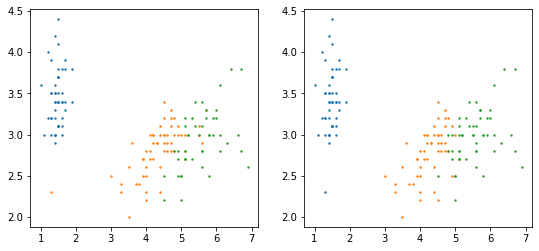

In [34]:
plt.figure(figsize=(9,4))
plt.subplot(121)
for k in range(n_classes):
    plt.scatter(X[class_assignments==k, 2], X[class_assignments==k, 1], s=2)
plt.subplot(122)
for k, class_name in enumerate(np.unique(Y)):
    plt.scatter(X[Y==class_name, 2], X[Y==class_name, 1], s=2)

## Visualization: PCA Projection

In [35]:
evals, evecs = np.linalg.eigh(np.cov(X.T))
to_crd = lambda x: ((x-x.mean(axis=0))@evecs)[:,-2:]
crds = to_crd(X)

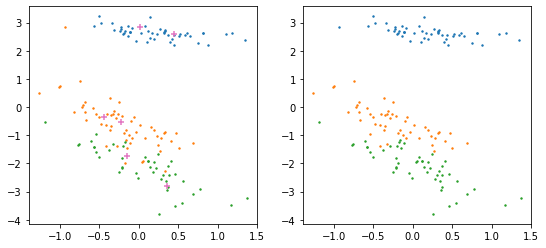

In [36]:
mean = np.array(mean)
plt.figure(figsize=(9,4))
plt.subplot(121)
for k in range(n_classes):
    plt.scatter(crds[class_assignments==k, 0], crds[class_assignments==k, 1], s=2)
plt.scatter(to_crd(mean)[:,0], to_crd(mean)[:,1], s=30, marker='+')
plt.subplot(122)
for k in np.unique(Y):
    plt.scatter(crds[Y==k, 0], crds[Y==k, 1], s=2)